<a href="https://colab.research.google.com/github/Userfound404/speech_recognition/blob/main/emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**About RAVDESS dataset**

This is the Ryerson Audio-Visual Database of Emotional Speech and Song dataset, and is free to download. This dataset has 7356 files rated by 247 individuals 10 times on emotional validity, intensity, and genuineness. The entire dataset is 24.8GB from 24 actors, but we’ve lowered the sample rate on all the files. In our model, we are taking the emotion (third identifier) in consideration only.

**File naming convention**

Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 
04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Download the dateset [here](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio). 

"The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0.

**Install and Import Libraries**

In [ ]:
!pip install opendatasets
!pip install pandas
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa as lib
import librosa.display 

import matplotlib.pyplot as plt
import seaborn as sns

import IPython.display as ipd 

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import activations

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

import pydotplus as pyd
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

**Download Dataset**

In [ ]:
od.download("https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: roxpox10
Your Kaggle Key: ··········


100%|██████████| 429M/429M [00:13<00:00, 33.2MB/s]


In [ ]:
Ravdess = "./ravdess-emotional-speech-audio/audio_speech_actors_01-24"

In [ ]:
# Emotions in the RAVDESS dataset, different numbers represent different emotion
# emotions = {
#     '01':'neutral',
#     '02':'calm',
#     '03':'happy',
#     '04':'sad',
#     '05':'angry',
#     '06':'fearful',
#     '07':'disgust',
#     '08':'surprised'
# }

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)
files = []
modality =[]
vocal =[]
emotion =[]
intensity =[]
statement =[]
repetition =[]
actor =[]
gender = []
time = []
audio_data = []
sr = []

max_row = 0
max_col = 0
min_row = 1000
min_col = 1000

n_fft = 2048
hop_length = 512
n_mels = 200

for file_name in ravdess_directory_list:
    file_path = Ravdess+'/'+ file_name
    mod, voc, emo, inten, state, repe, act = file_name.split('-')
    act = act.split('.')[0]
    
    if emo != '02':
        #store metadata
        files.append(file_name)
        modality.append(mod)
        vocal.append(voc)
        #emotion.append(emo)
        intensity.append(inten)
        statement.append(state)
        repetition.append(repe)
        actor.append(act)

        if (emo == '01'):
            emotion.append('neutral')
        elif (emo == '03'):
            emotion.append('happy')
        elif (emo == '04'):
            emotion.append('sad')
        elif (emo == '05'):
            emotion.append('angry')
        elif (emo == '06'):
            emotion.append('fearful')
        elif (emo == '07'):
            emotion.append('disgust')
        elif (emo == '08'):
            emotion.append('surprised')

        if (int(act) % 2 == 0):
            gender.append(1) #female
        else:
            gender.append(2) #male

        audio, sfreq = lib.load(file_path, sr=44100,offset=0.5,duration = 3.5)
        time_line = np.arange(0,len(audio)) / sfreq
        time.append(time_line)
        audio_data.append(audio)
        sr.append(sfreq)

        #mfccs = lib.feature.mfcc(y=audio,sr=sfreq,n_mfcc=25)
        mfccs = librosa.feature.mfcc(y=audio, sr=sfreq, n_mfcc=13)
        mel_spec = lib.feature.melspectrogram(audio, sr=sfreq, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        S_DB = lib.power_to_db(mel_spec, ref=np.max)

        if (S_DB.shape[0] > max_row):
            max_row = S_DB.shape[0]

        if (S_DB.shape[1] > max_col):
            max_col = S_DB.shape[1]

        if (S_DB.shape[0] < min_row):
            min_row = S_DB.shape[0]

        if (S_DB.shape[1] < min_col):
            min_col = S_DB.shape[1]
            
        
print("DONE !")

ValueError: ignored

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are different directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

NameError: ignored

**Loading dataset**

There is a total of *8 emotions* that can be observed in the RAVDESS dataset.

Each file in the RAVDESS dataset has a unique filename. The filename consists of 7 numbers separated by dashes (e.g. 02-01-06-01-02-01-12.mp4).

 These numbers define the stimulus characteristics in the following order:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only)

Vocal channel (01 = speech, 02 = song)
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door")

Repetition (01 = 1st repetition, 02 = 2nd repetition)

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female)

In [ ]:
data_path = Ravdess_df
data_path.to_csv("data_path.csv",index=False)
data_path.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotions  1440 non-null   object
 1   Path      1440 non-null   object
dtypes: object(2)
memory usage: 22.6+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


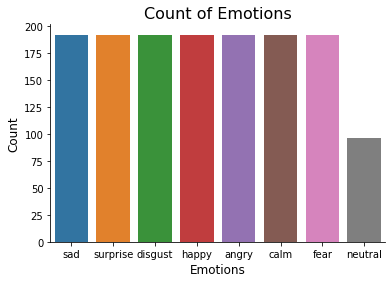

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

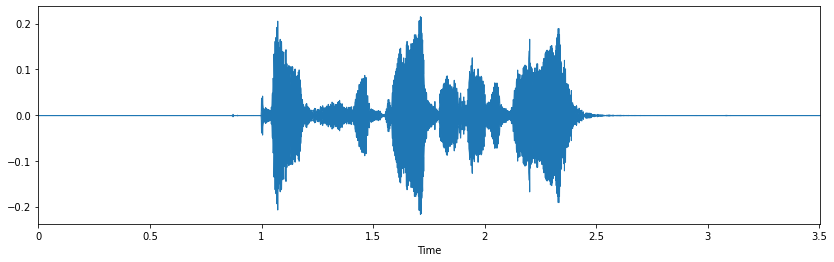

In [ ]:
#visualizing a single audio file
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)